## Carregar o dataset e as libs necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('sao-paulo-properties-april-2019.csv')

In [3]:
data

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000,420,51,2,1,0,1,0,0,0,0,Jabaquara/São Paulo,sale,apartment,-23.653004,-46.635463
13636,545000,630,74,3,2,1,2,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.648930,-46.641982
13637,515000,1100,114,3,3,1,1,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.649693,-46.649783
13638,345000,48,39,1,2,1,1,0,1,1,0,Jabaquara/São Paulo,sale,apartment,-23.652060,-46.637046


## AED do dataset

In [4]:
data['Negotiation Type'].value_counts()

Negotiation Type
rent    7228
sale    6412
Name: count, dtype: int64

### Filtrar apenas para o tipo de negociacao "sale" - imóveis a venda

In [5]:
df = data[data['Negotiation Type'] == 'sale']

In [6]:
df

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000,420,51,2,1,0,1,0,0,0,0,Jabaquara/São Paulo,sale,apartment,-23.653004,-46.635463
13636,545000,630,74,3,2,1,2,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.648930,-46.641982
13637,515000,1100,114,3,3,1,1,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.649693,-46.649783
13638,345000,48,39,1,2,1,1,0,1,1,0,Jabaquara/São Paulo,sale,apartment,-23.652060,-46.637046


In [7]:
df.shape

(6412, 16)

### Verificar a proporção dos imóveis a venda

In [8]:
percent_builds_rent = len(df)/len(data)
print(f'Os imoveis que estão disponiveis para comprar representa certa de {percent_builds_rent*100:.2f}% da base de dados.')

Os imoveis que estão disponiveis para comprar representa certa de 47.01% da base de dados.


### Analisar mais informações sobre as variáveis disponíveis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6412 entries, 4901 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             6412 non-null   int64  
 1   Condo             6412 non-null   int64  
 2   Size              6412 non-null   int64  
 3   Rooms             6412 non-null   int64  
 4   Toilets           6412 non-null   int64  
 5   Suites            6412 non-null   int64  
 6   Parking           6412 non-null   int64  
 7   Elevator          6412 non-null   int64  
 8   Furnished         6412 non-null   int64  
 9   Swimming Pool     6412 non-null   int64  
 10  New               6412 non-null   int64  
 11  District          6412 non-null   object 
 12  Negotiation Type  6412 non-null   object 
 13  Property Type     6412 non-null   object 
 14  Latitude          6412 non-null   float64
 15  Longitude         6412 non-null   float64
dtypes: float64(2), int64(11), object(3)
memory 

### Analisar as estatísticas das variáveis
- Média
- Desvio padrão
- Quartis, entre outros

Tudo isso ajuda no entendimento dos dados que temos disponíveis para construir a rede neural e ajudar na previsão do modelo.

In [10]:
df.describe()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
count,6.412000e+03,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,6.086241e+05,537.349813,78.611042,2.320805,2.037742,0.931535,1.326575,0.415471,0.117280,0.539457,0.032283,-22.127513,-43.705547
std,7.404515e+05,624.632473,50.872359,0.714743,0.917844,0.772615,0.751658,0.492841,0.321779,0.498480,0.176765,5.756660,11.271783
min,4.200000e+04,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.734483,-49.337815
25%,2.500000e+05,150.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-23.592848,-46.673526
50%,3.800000e+05,400.000000,62.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-23.549693,-46.628506
75%,6.790000e+05,700.000000,87.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,-23.512534,-46.533612
max,1.000000e+07,8920.000000,620.000000,6.000000,7.000000,6.000000,7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


#### Preço médio dos imóveis a venda

In [11]:
# média dos preços dos imóveis
media_dos_imoveis = round(float(df.describe()['Price']['mean']), 2)
media_dos_imoveis

608624.14

#### Analisar as distribuições de forma geral das variáveis

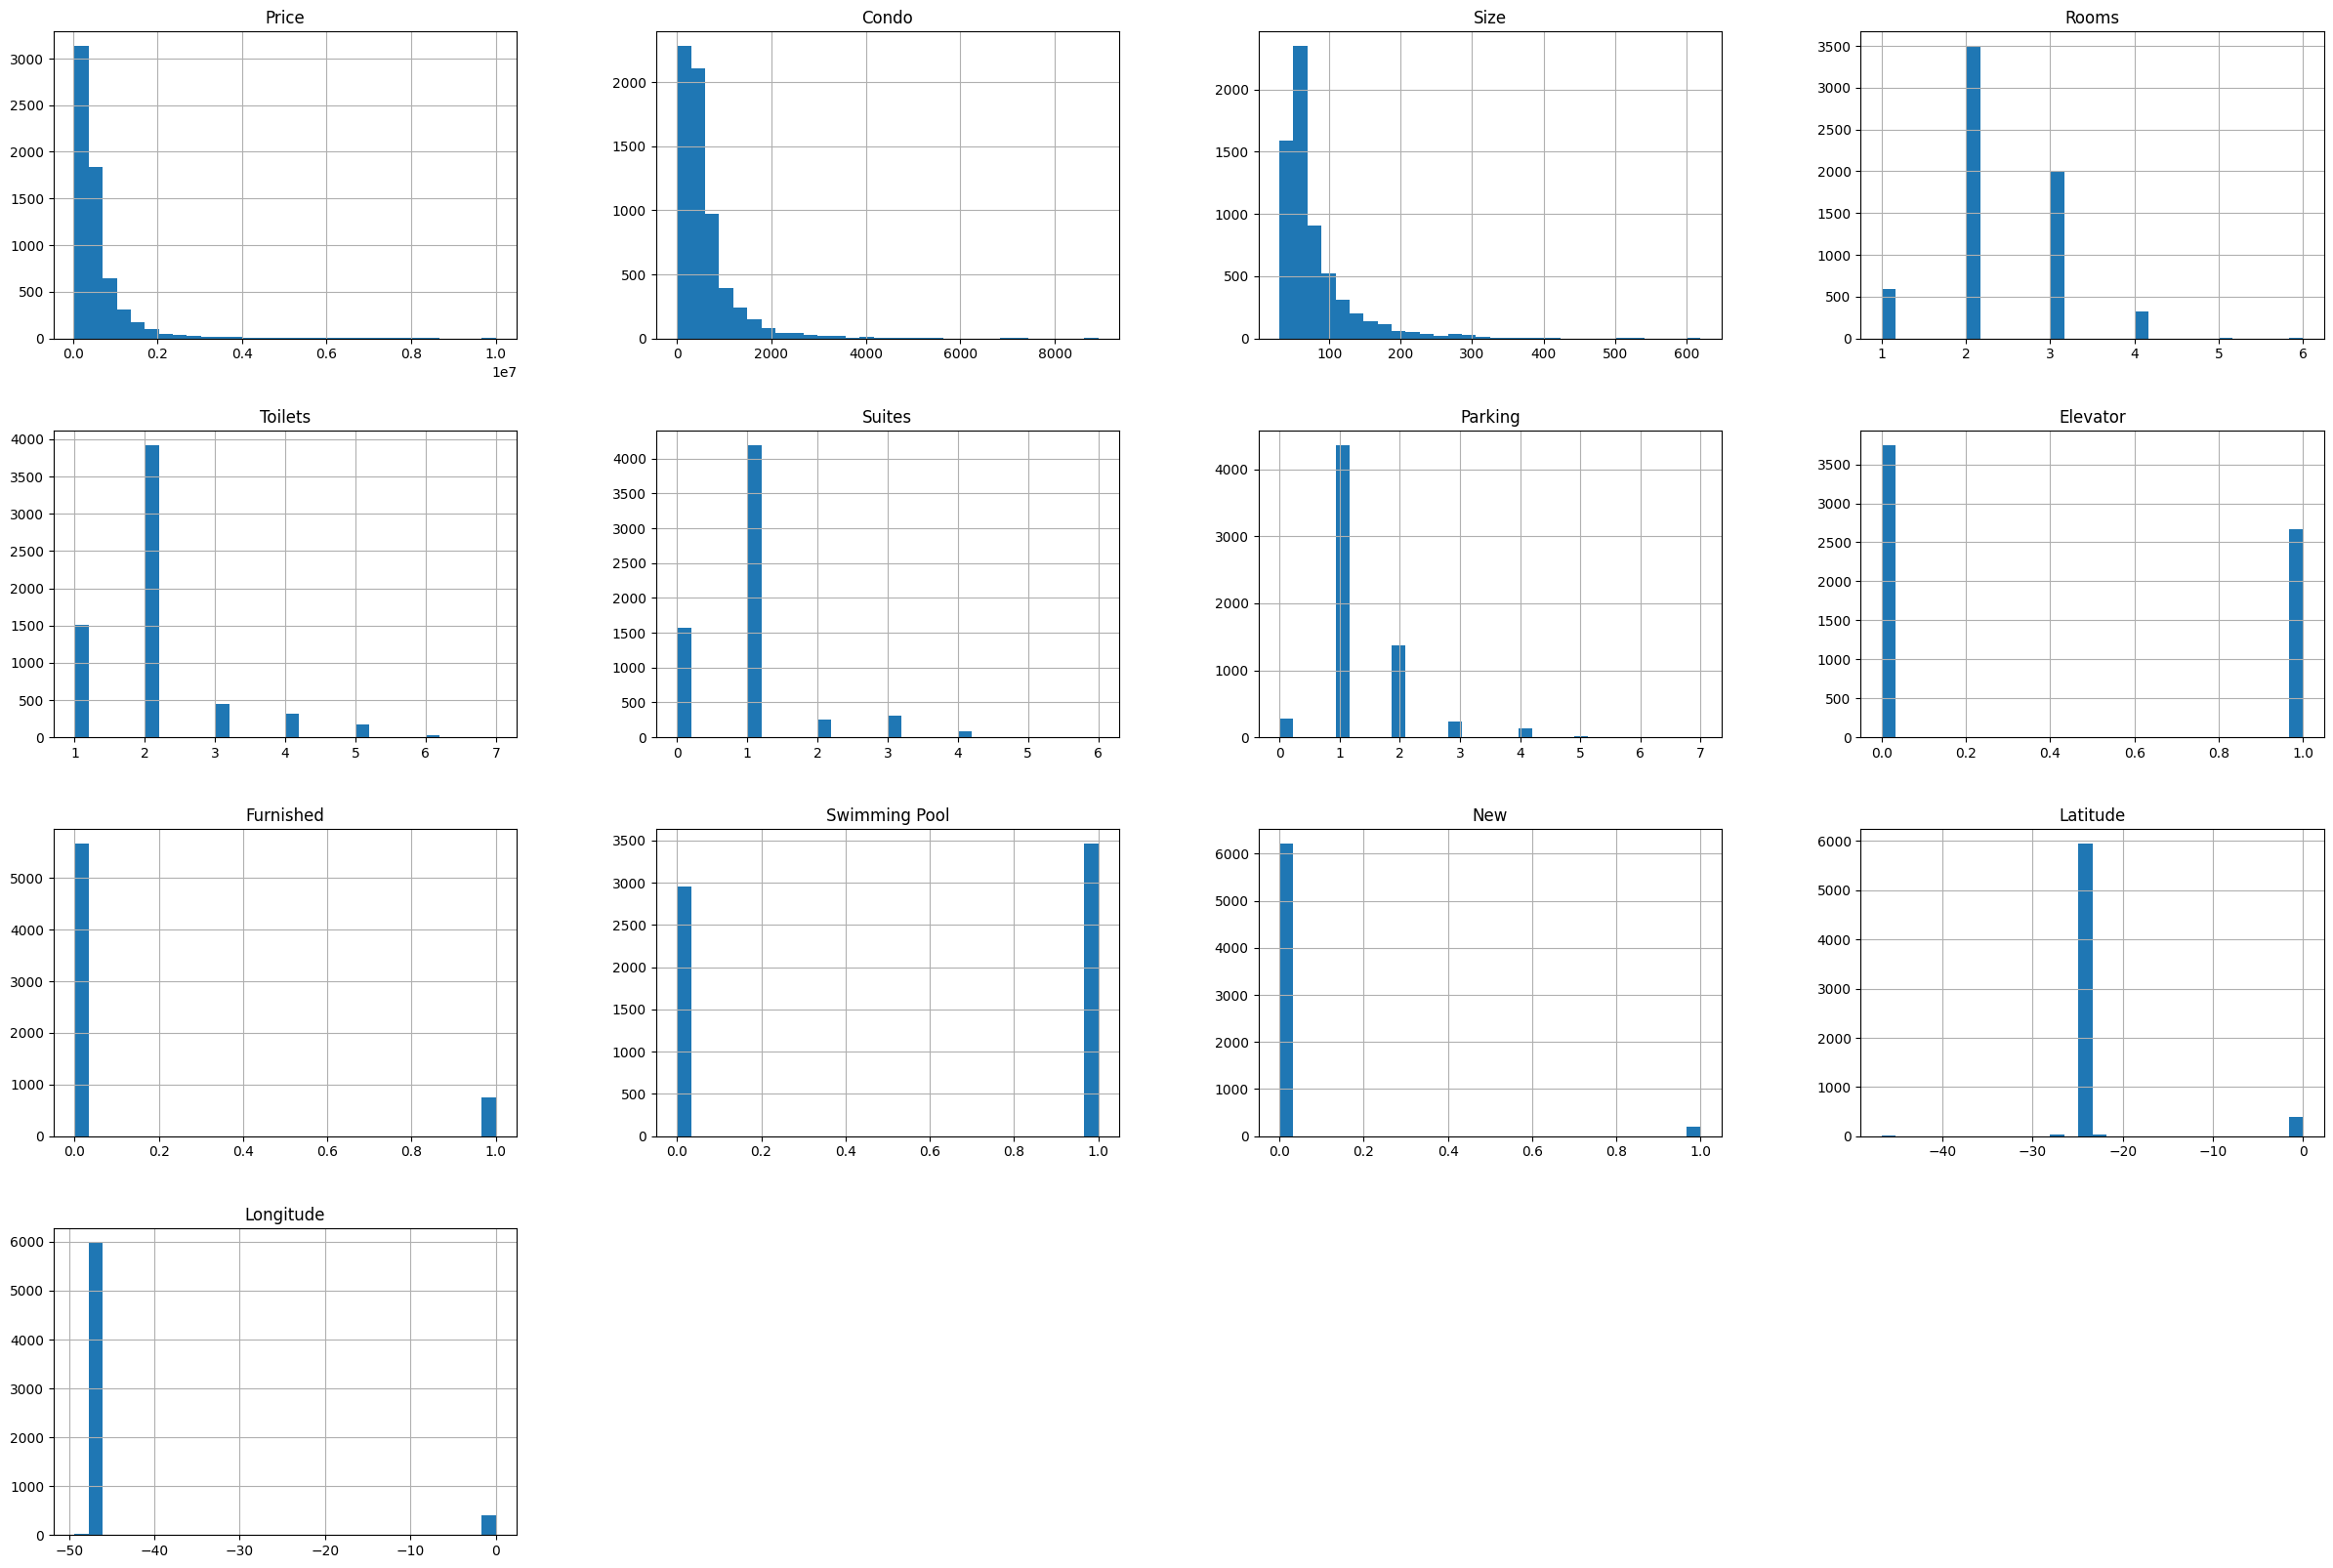

In [12]:
df.hist(bins=30, figsize=(30,20))
plt.show()

#### Os preços mais comuns dos imóveis - Top 5

In [13]:
df['Price'].value_counts().head()

Price
250000    97
240000    94
350000    93
320000    80
280000    80
Name: count, dtype: int64

#### Preço médio dos preços mais comuns dos imóveis - Top 5

In [14]:
# media de preco do top5 imoveis
float(df['Price'].value_counts().reset_index().head()['Price'].mean())

288000.0

A média de preço do top 5 imovéis dentro do conjunto de dados é de R$ 288.000,00

#### Verificar a distribuição dos preços dos imóveis a venda

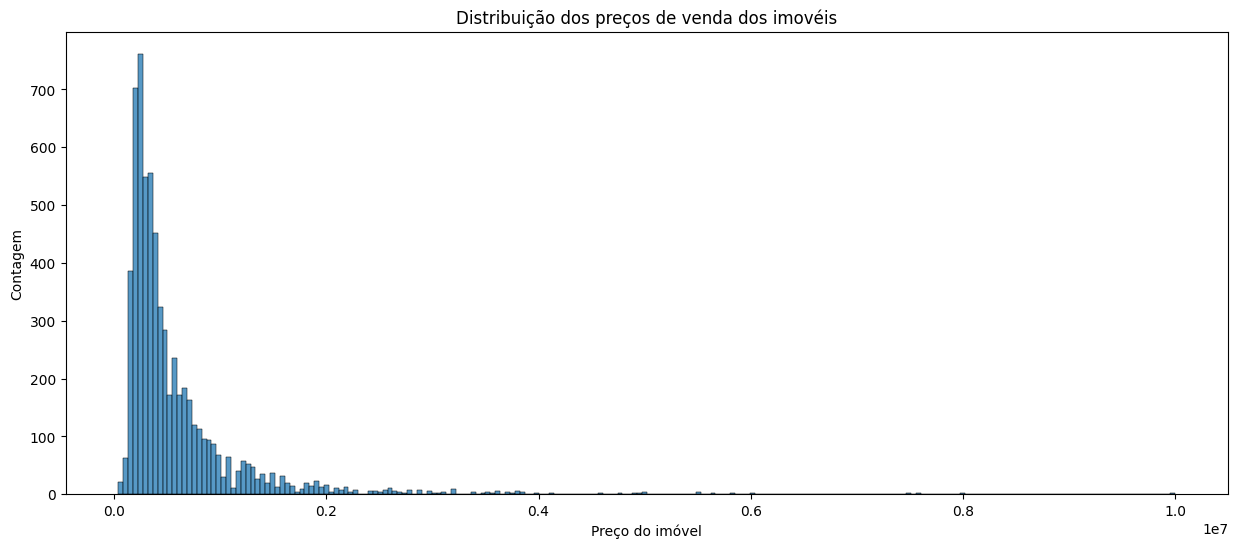

In [15]:
plt.figure(figsize=(15,6))
sns.histplot(df['Price'])
plt.title('Distribuição dos preços de venda dos imovéis')
plt.xlabel('Preço do imóvel')
plt.ylabel('Contagem')
plt.show()

#### Verificar quantos imóveis exitem abaixo do preço médio geral

In [16]:
# quantidade de imoveis abaixo da media geral de preço
quantidade_imoveis_abaixo_avg = len(df.loc[df['Price'] <= media_dos_imoveis]['Price'])
print('Quantidade de imóvesi abaixo da média geral de preço:', quantidade_imoveis_abaixo_avg)

Quantidade de imóvesi abaixo da média geral de preço: 4551


#### Verificar a proporção dos imóveis que estão abaixo do preço médio geral

In [17]:
# verificando a proporção da quantidade de imóveis abaixo a da média geral
proporcao_imoveis_abaixo_avg = round((quantidade_imoveis_abaixo_avg / df.shape[0])*100, 2)
print(f'Proporção da quantidade de imóveis abaixo da média geral: {proporcao_imoveis_abaixo_avg}%')

Proporção da quantidade de imóveis abaixo da média geral: 70.98%


> Cerca de 71% dos imóveis disponíveis para a venda estão abaixo da média geral. Enfatizando a distribuição dos preços no histograma acima.

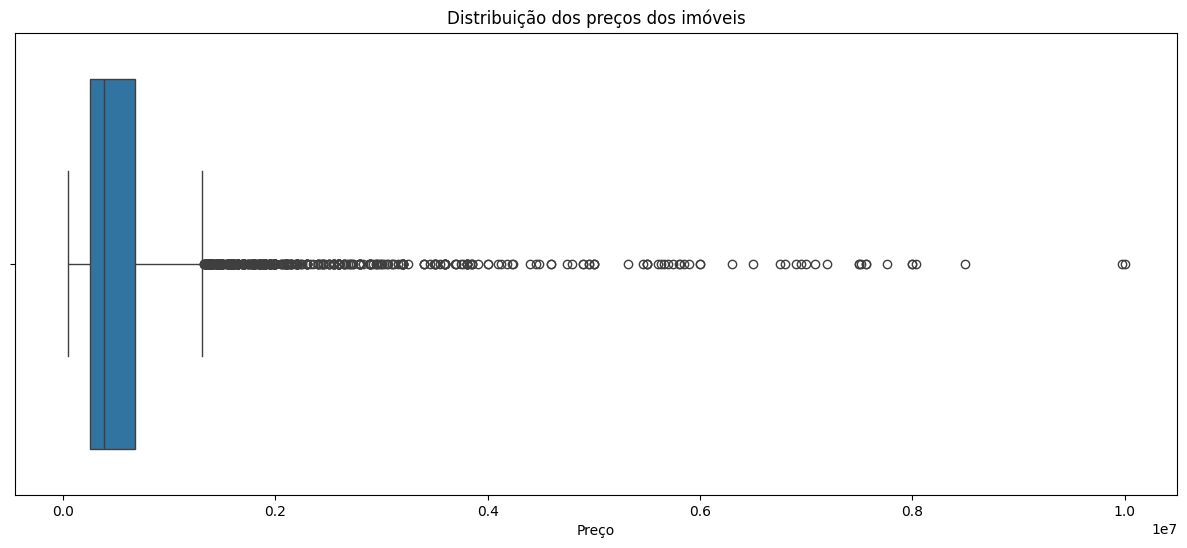

In [18]:
plt.figure(figsize=(15,6))
sns.boxplot(df['Price'], orient='h')
plt.title('Distribuição dos preços dos imóveis')
plt.xlabel('Preço')
plt.show()

#### Analisar a distribuição dos preços pelos distritos na cidade de São Paulo

In [19]:
df['District'].value_counts()

District
Casa Verde/São Paulo        149
Bom Retiro/São Paulo        147
Brooklin/São Paulo          139
Bela Vista/São Paulo        136
Moema/São Paulo             130
                           ... 
Cachoeirinha/São Paulo       31
Perus/São Paulo              30
Freguesia do Ó/São Paulo     30
Jaraguá/São Paulo            22
Iguatemi/São Paulo           20
Name: count, Length: 96, dtype: int64

In [20]:
# quantidade de distritos unicos
df['District'].nunique()

96

ATTENTION: verificar essa parte depois

In [21]:
K = 10

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

df['Cluster'] = df['Cluster'].astype(str)

fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', 
                        color='Cluster', size='Size',
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        size_max=20, zoom=10, opacity=0.4,
                        hover_name='District',
                        template='plotly_dark')
fig.update_layout(height=1000,
                  mapbox=dict(center=go.layout.mapbox.Center(lat=-23.543138, lon=-46.69486)))

fig.show()

In [22]:
fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', color='Price', size='Size', color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10, opacity=0.4, template='plotly_dark')
fig.update_layout(height=1000, mapbox=dict(center=go.layout.mapbox.Center(lat=-23.543138, lon=-46.69486)))
fig.update_coloraxes(colorscale = [
    [0, 'rgb(166,206,227,0.5)'],
    [0.02, 'rgb(31,120,180,0.5)'],
    [0.05, 'rgb(178,223,138,0.5)'],
    [0.10, 'rgb(51,160,44,0.5)'],
    [0.15, 'rgb(251,154,153,0.5)'],
    [1, 'rgb(227,26,28,0.5)'],
])
fig.show()

### Analisar correlação entre as variáveis
Antes de treinar nosso modelo de previsão de preços de imóveis, é essencial entender como as variáveis do nosso conjunto de dados se relacionam entre si, especialmente em relação a variável target (Price).

A correlação nos ajuda a identificar:

- Quais variáveis têm maior impacto no preço do imóvel (correlação forte positiva ou negativa).
- Quais variáveis podem ser redundantes (altamente correlacionadas entre si, podendo causar multicolinearidade).
- Quais variáveis podem ter pouca ou nenhuma influência direta no preço (correlação próxima de 0).

In [23]:
df.loc[:, ~df.columns.isin(['District', 'Negotiation Type', 'Property Type'])].corr()['Price'].sort_values(ascending=False)

Price            1.000000
Size             0.825660
Parking          0.701849
Toilets          0.636782
Suites           0.623177
Condo            0.614456
Rooms            0.490255
Swimming Pool    0.177950
Elevator         0.066966
Furnished        0.061968
Latitude        -0.030126
Longitude       -0.034988
New             -0.036857
Cluster         -0.265971
Name: Price, dtype: float64

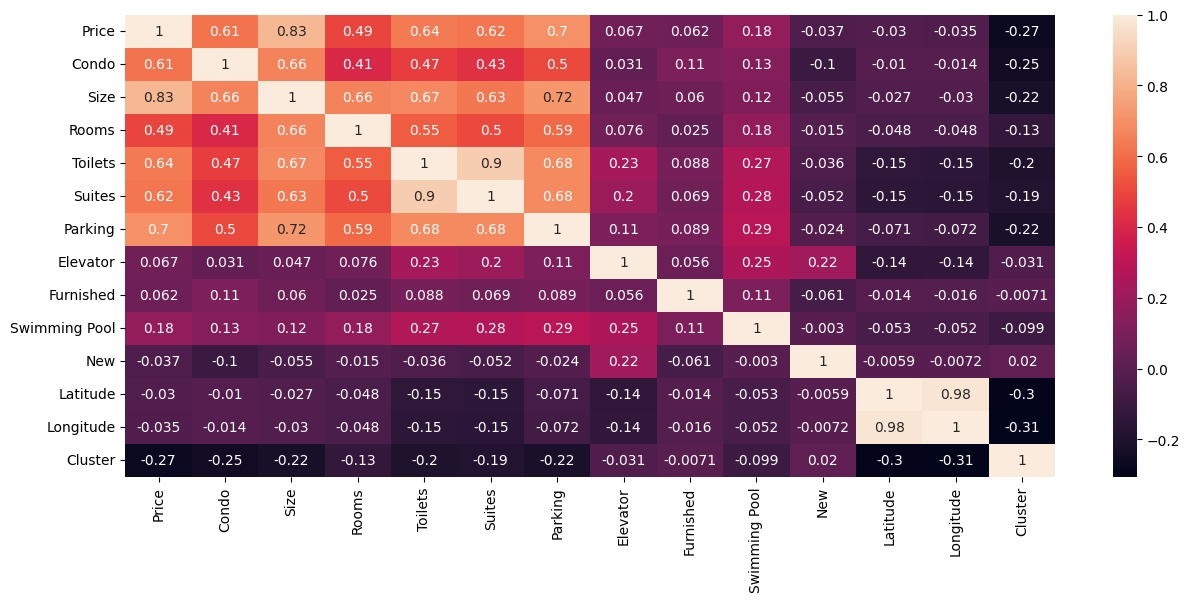

In [24]:
plt.figure(figsize=(15,6))
sns.heatmap(df.loc[:, ~df.columns.isin(['District', 'Negotiation Type', 'Property Type'])].corr(), annot=True)
plt.show()

Temos boas variáveis correlacionando com a target. Entretanto, precisamos verificar as variáveis de geolocalização. Para que possamos ter mais precisão e menos ruído no treinamento, porém sem perder essa informação de localização, vamos utilizar o KMeans e fazer uma clusterização geográfica para reduzir a dimensionalidade com o objetivo de agrupar os imóveis em regiões ou zonas.

## Tratamento dos dados

In [25]:
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Cluster
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244,6
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106,0
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594,6
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104,6
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890,0


In [26]:
df_cleaned = df.drop(['Negotiation Type', 'Property Type', 'Latitude', 'Longitude', 'Cluster'], axis=1)
df_cleaned.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo


## Preparação de dados para modelos de ML

In [27]:
X = df_cleaned.drop('Price', axis=1)
X

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
4901,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo
4902,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo
4903,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo
4904,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo
4905,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo
...,...,...,...,...,...,...,...,...,...,...,...
13635,420,51,2,1,0,1,0,0,0,0,Jabaquara/São Paulo
13636,630,74,3,2,1,2,0,0,1,0,Jabaquara/São Paulo
13637,1100,114,3,3,1,1,0,0,1,0,Jabaquara/São Paulo
13638,48,39,1,2,1,1,0,1,1,0,Jabaquara/São Paulo


In [28]:
y = df['Price'].values
y

array([ 732600, 1990000,  720000, ...,  515000,  345000,  161987],
      shape=(6412,))

#### Pré-processador para normalizar variáveis numéricas e codificar as variáveis categóricas

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['District'])
    ]
)

In [30]:
X_processed = preprocessor.fit_transform(X)

In [31]:
X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [32]:
print(X_tensor.shape, y_tensor.shape)

torch.Size([6412, 102]) torch.Size([6412, 1])


## Treinamento de modelos

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

### Definir o modelo da rede neural para previsão dos preços dos imóveis

In [34]:
class HousePriceNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

#### Inicializar o modelo

In [35]:
input_dim = X_train.shape[1]
model = HousePriceNN(input_dim)

#### Definir a loss function e o optimizer

In [36]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

#### Treinamento

In [38]:
epochs = 100
for epoch in range(epochs):
    for batch in train_loader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Época [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Época [0/100], Loss: 237683867648.0000
Época [20/100], Loss: 1263304966144.0000
Época [40/100], Loss: 88003502080.0000
Época [60/100], Loss: 25117104128.0000
Época [80/100], Loss: 54252519424.0000


In [39]:
y_pred = model(X_tensor).detach().numpy()
y_true = y_tensor.numpy()

r2 = r2_score(y_true, y_pred)
print(f'Novo R² do modelo: {r2:.4f}')

Novo R² do modelo: 0.8633


In [40]:
mae = mean_absolute_error(y_true, y_pred)
print(f'Erro Absoluto Médio (MAE): {mae:.2f}')

Erro Absoluto Médio (MAE): 129767.09


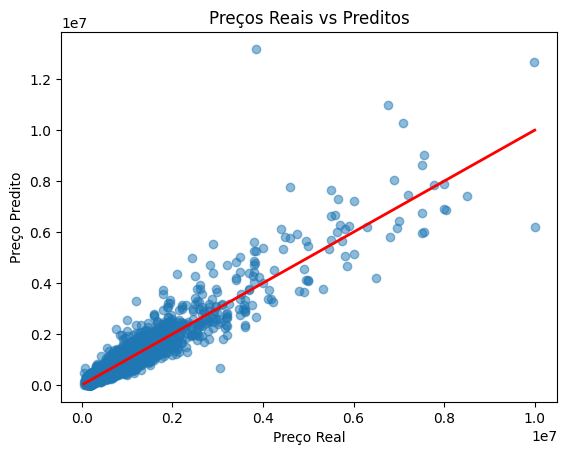

In [41]:
# plotar as previsões versus valores reais
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
plt.xlabel('Preço Real')
plt.ylabel('Preço Predito')
plt.title('Preços Reais vs Preditos')
plt.show()
